In [51]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
from visualize import draw_dot

In [52]:
from nn import Linear, Model
from optimize import Adam


l1 = Linear(1, 50)
l2 = Linear(50, 1, nonlinear=False)
batch_size=1

model = Model([l1, l2])
optim = Adam(model)

In [53]:
X = np.random.uniform(0, 10000000, 1000)
Y = 2*X**2

X_norm = (X - np.mean(X)) / np.std(X)
Y_norm = (Y - np.mean(Y)) / np.std(Y)

In [54]:
for _ in (t:=trange(2000)):
    ix = np.random.randint(0, X_norm.shape[0], (batch_size,)).flatten()

    out = model(X_norm[ix])
    
    optim.zero_grad()

    if (batch_size > 1):
        batch_loss = sum([((val-Y_norm[ix][i])**2)/batch_size for i, val in enumerate(out)])
        batch_loss.backward()
    
    else:
        loss = (out-Y_norm[ix][0])**2
        loss.backward()

    optim.step()

    t.set_description(f'loss: {batch_loss.data}')

loss: 0.0004344420893167338: 100%|██████████| 2000/2000 [00:07<00:00, 270.78it/s]


In [55]:
avg_loss = 0
count = 0
for x, y in zip(X_norm, Y_norm):
    out = model([x])
    loss = (out - y) ** 2
    avg_loss += loss.data
    count += 1
print(f'avg_loss: {avg_loss/count}')

avg_loss: 0.015987770544447145


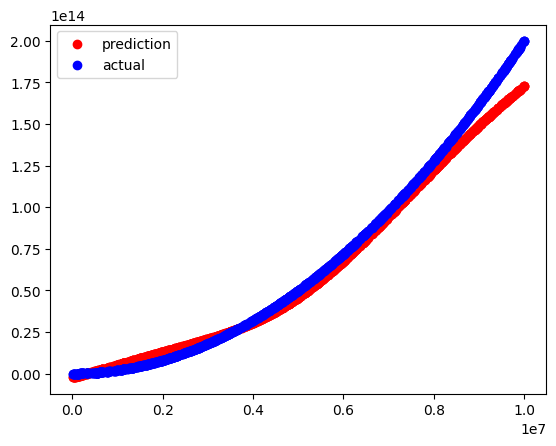

In [56]:
plt.scatter(X, np.array([model([x]).data for x in X_norm]) * np.std(Y) + np.mean(Y), c='r', label='prediction')
plt.scatter(X, Y, c='b', label='actual')
plt.legend()

In [760]:
l1 = Linear(1, 50)
l2 = Linear(50, 1, nonlinear=False)

model = Model([l1, l2])

In [765]:
avg_loss = 0
count = 0
for x, y in zip(X_norm, Y_norm):
    out = model([x])
    loss = (out - y) ** 2
    avg_loss += loss.data
    count += 1
print(f'avg_loss: {avg_loss/count}')

avg_loss: [0.0607194]


In [762]:
X = np.random.uniform(0, 10000000, 1000)
Y = 2*X**2

X_norm = (X - np.mean(X)) / np.std(X)
Y_norm = (Y - np.mean(Y)) / np.std(Y)

In [763]:
for _ in (t:=trange(10000)):
    ix = np.random.randint(0, X.shape[0], (1,))
    logits = model(X_norm[ix])

    loss = (logits - Y_norm[ix])**2

    model.zero_grad()

    loss.backward()

    loss.step()
    
    t.set_description(f'loss: {loss.data[0]:.4}')

loss: 0.2543:  10%|█         | 1044/10000 [00:06<00:51, 172.93it/s]   


KeyboardInterrupt: 

In [24]:
input_value = 60
normalized_input = (input_value - np.mean(X)) / np.std(X)

# Making a prediction
normalized_output = model([normalized_input])

# Denormalizing the output
denormalized_output = (normalized_output * np.std(Y)) + np.mean(Y)

denormalized_output

data: [376299.222715], grad: 0, op: +

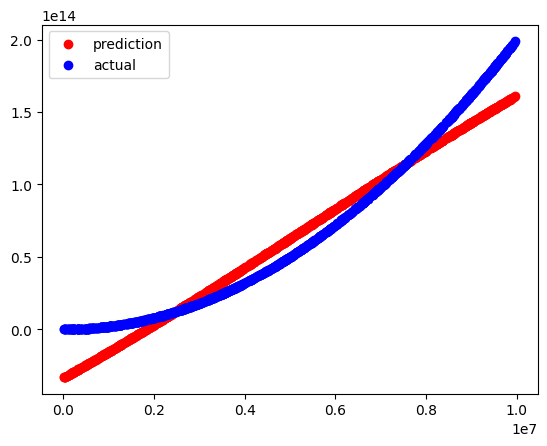

In [764]:
plt.scatter(X, np.array([model([x]).data for x in X_norm]) * np.std(Y) + np.mean(Y), c='r', label='prediction')
plt.scatter(X, Y, c='b', label='actual')
plt.legend()

In [13]:
words = open('words.txt', 'r').read().splitlines()
random.shuffle(words)
content_len = 1
feature_count = 10

chars = sorted(set('.'.join(words)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

def build_dataset(words):
    X, Y = [], []
    context = [0] * content_len
    for word in words:
        word += '.'
        for c in word:
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [14]:
Xtrain, Ytrain = build_dataset(words)

C = Embedding(27, feature_count)
l1 = Linear(content_len * feature_count, 75)
l2 = Linear(75, 27, nonlinear=False)

model = Model([C, l1, l2])

In [18]:
import queue
import threading
import time

q = queue.Queue()

for i in [3, 2,1]:
    def f():
        time.sleep(i)
        q.put(i)
    threading.Thread(target=f).start()

print(q.get())

1


In [15]:
for _ in (t:=trange(300)):
    ix = int(np.random.randint(0, Xtrain.shape[0], (1,)))

    out = model(Xtrain[ix])

    expected = Ytrain[ix]

    maxVal = max([num.data for num in out])

    exp = [(2**(num-maxVal)) for num in out]

    count = sum([num.data for num in exp])

    prob = [val/count for val in exp]

    loss = prob[int(Ytrain[ix])].log()*-1

    model.zero_grad()

    loss.backward()

    loss.step(lr=0.01)
    
    t.set_description(f'loss: {loss.data}')

loss: 3.272425614919388:  37%|███▋      | 110/300 [00:05<00:09, 19.33it/s] 


KeyboardInterrupt: 

In [16]:
avg_loss = 0
countt = 0
random.shuffle(words)
for word in words[:10]:
    for ch1, ch2 in zip(word, word[1:]):
        input = [stoi[ch1]]
        expected = stoi[ch2]
        out = model(input)

        maxVal = max([num.data for num in out])

        exp = [(2**(num-maxVal)) for num in out]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(expected)].log()*-1

        avg_loss += loss.data
        countt += 1

print(f'loss: {avg_loss/countt}')

loss: 3.2857463631662767
